# exploring data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2       # type: ignore
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [12]:
train_path = '/home/theodoros/dataset/GTSRB/Final_Training/Images'
test_path = '/home/theodoros/dataset/GTSRB/Final_Test/Images'

In [13]:
def process_image(img_path, resizeSize):
    img = cv2.imread(img_path)
    img_resize = cv2.resize(img, resizeSize)
    img_norm = img_resize / 255.0
    gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

    hog_desc, hog_image = hog(
        gray,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return img_norm, keypoints, descriptors, hog_desc, hog_image

def loadData(path, load_type, resizeSize=(32, 32)):
    images = []
    labels = []
    bboxes = []
    sift_features = []
    sift_keypoints = []
    hog_features = []
    hog_images = []

    if load_type == "Train":
        class_dirs = sorted(os.listdir(path))

        for class_id in class_dirs:
            class_dir = os.path.join(path, class_id)
            class_label = int(class_id)
            annotation_file = os.path.join(class_dir, f'GT-{class_id}.csv')
            annotations = pd.read_csv(annotation_file, sep=";")

            for _, row in annotations.iterrows():
                img_path = os.path.join(class_dir, row['Filename'])

                img_norm, keypoints, descriptors, hog_desc, hog_image = process_image(img_path, resizeSize)

                if descriptors is None:
                    continue

                bbox = {
                    'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                    'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                    'original_width': row['Width'], 'original_height': row['Height']
                }

                images.append(img_norm)
                labels.append(class_label)
                bboxes.append(bbox)
                sift_keypoints.append(keypoints)
                sift_features.append(descriptors)
                hog_features.append(hog_desc)
                hog_images.append(hog_image)
        
        print("Done, Train Images are loaded.")

    elif load_type == "Test":
        annotation_file = "/home/theodoros/dataset/GT-final_test.csv"
        annotations = pd.read_csv(annotation_file, sep=";")

        for _, row in annotations.iterrows():
            img_path = os.path.join(path, row['Filename'])
            class_label = int(row['ClassId'])

            img_norm, keypoints, descriptors, hog_desc, hog_image = process_image(img_path, resizeSize)

            if descriptors is None:
                continue

            bbox = {
                'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                'original_width': row['Width'], 'original_height': row['Height']
            }

            images.append(img_norm)
            labels.append(class_label)
            bboxes.append(bbox)
            sift_keypoints.append(keypoints)
            sift_features.append(descriptors)
            hog_features.append(hog_desc)
            hog_images.append(hog_image)
        
        print("Done, Test Images are loaded.")

    X = np.array(images)
    y = np.array(labels)

    return X, y, bboxes, sift_features, sift_keypoints, hog_features, hog_images

# testing loading

In [14]:
X_train, y_train, bboxes_train, sift_features_train, sift_keypoints_train, hog_features_train, hog_images_train = loadData(train_path, "Train")
X_test, y_test, bboxes_test, sift_features_test, sift_keypoints_test, hog_features_test, hog_images_test = loadData(test_path, "Test")

Done, Train Images are loaded.
Done, Test Images are loaded.


(35423, 32, 32, 3)
(35423,)


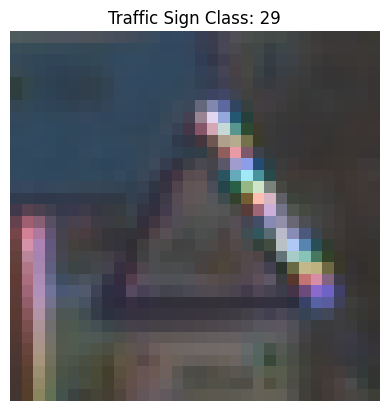

In [15]:
print(X_train.shape)  # N of images , hiehgt , width , channels 3 bcs we are on RGP
print(y_train.shape)

test_img = random.randint(0, X_train.shape[0])
plt.Figure(figsize=(5,5))

plt.imshow(X_train[test_img])
plt.title(f"Traffic Sign Class: {y_train[test_img]}")
plt.axis('off')
plt.show()

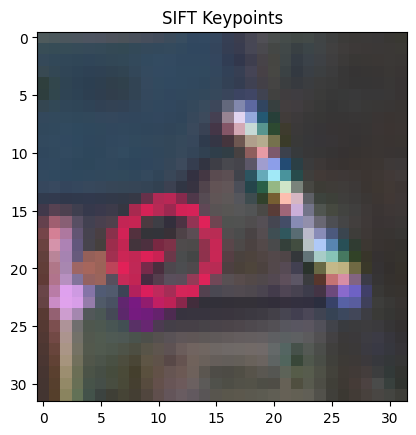

In [16]:
image_uint8 = (X_train[test_img] * 255).astype(np.uint8)
image_with_keypoints = cv2.drawKeypoints(image_uint8, sift_keypoints_train[test_img], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints, cmap="gray")
plt.title("SIFT Keypoints")
plt.show()

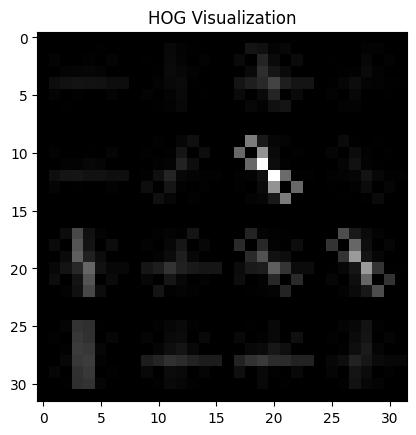

In [17]:
plt.imshow(hog_images_train[test_img], cmap='gray')
plt.title("HOG Visualization")
plt.show()

### Training svm with Plain Images Vs HOG Features

In [20]:
X_train = X_train.reshape(-1, 32*32*3)

In [22]:
# svm_plain = SVC(kernel='linear', probability=True, random_state=42)
#svm_plain.fit(X_train, y_train) ## just the Images as it is
svm_hog = SVC(kernel='linear', probability=True, random_state=42)
svm_hog.fit(hog_features_train, y_train)

#_pred_plain = svm_plain.predict(X_test)
y_pred_hog = svm_hog.predict(hog_features_test)
#accuracy_plain = accuracy_score(y_test, y_pred_plain)
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Plain Images Accuracy: \nHOG Features Accuracy: {accuracy_hog}")

Plain Images Accuracy: 
HOG Features Accuracy: 0.8051800819743612


In [31]:
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, load_type='Train', resize_size=(64, 64), transform=None, use_features=True):
        self.root_dir = root_dir
        self.load_type = load_type
        self.resize_size = resize_size
        self.transform = transform
        self.use_features = use_features
        self.data = []
        self._load_data()

    def _load_data(self):
        if self.load_type == "Train":
            class_dirs = sorted(os.listdir(self.root_dir))
            for class_id in class_dirs:
                class_dir = os.path.join(self.root_dir, class_id)
                class_label = int(class_id)
                annotation_file = os.path.join(class_dir, f'GT-{class_id}.csv')
                annotations = pd.read_csv(annotation_file, sep=';')

                for _, row in annotations.iterrows():
                    self.data.append({
                        'img_path': os.path.join(class_dir, row['Filename']),
                        'label': class_label,
                        'bbox': {
                            'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                            'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                            'original_width': row['Width'], 'original_height': row['Height']
                        }
                    })
        elif self.load_type == "Test":
            annotation_file = "/home/theodoros/dataset/GT-final_test.csv"
            annotations = pd.read_csv(annotation_file, sep=';')

            for _, row in annotations.iterrows():
                self.data.append({
                    'img_path': os.path.join(self.root_dir, row['Filename']),
                    'label': int(row['ClassId']),
                    'bbox': {
                        'x1': row['Roi.X1'], 'y1': row['Roi.Y1'],
                        'x2': row['Roi.X2'], 'y2': row['Roi.Y2'],
                        'original_width': row['Width'], 'original_height': row['Height']
                    }
                })

    def _process_image(self, img_path):
        img = cv2.imread(img_path)
        img_resize = cv2.resize(img, self.resize_size)
        img_norm = img_resize / 255.0
        gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

        if self.use_features:
            hog_desc, hog_image = hog(
                gray,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True,
                feature_vector=True
            )

            sift = cv2.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            return img_norm, keypoints, descriptors, hog_desc, hog_image
        else:
            return img_norm, None, None, None, None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = item['img_path']
        label = item['label']
        bbox = item['bbox']

        img_norm, keypoints, descriptors, hog_desc, hog_image = self._process_image(img_path)

        image_tensor = torch.tensor(img_norm, dtype=torch.float).permute(2, 0, 1)  ## CHW format

        if self.transform:
            image_tensor = self.transform(image_tensor)

        sample = {
            'image': image_tensor,
            'label': torch.tensor(label, dtype=torch.long),
            'bbox': bbox
        }

        if self.use_features:
            if descriptors is None:
                descriptors = np.zeros((1, 128), dtype=np.float32)
            sample.update({
                'sift_features': descriptors,
                'hog_features': torch.tensor(hog_desc, dtype=torch.float),
                'hog_image': torch.tensor(hog_image, dtype=torch.float)
            })

        return sample

In [24]:
class SimpleResCNN(nn.Module):
    def __init__(self, num_classes=43):  ## Our dataset (GTSRB) has 43 classes
        super(SimpleResCNN, self).__init__()
        
        ## (first convvv)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  ## 64 -> 32
        )
        
        ## (second convvv + skip conn)
        self.conv2_main = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.conv2_skip = nn.Conv2d(32, 64, kernel_size=1)

        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  ## 32 -> 16

        ## (another final conv, like a combiner one)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  ## 16 -> 8
        )

        ## Classifier (final step)
        self.gap = nn.AdaptiveAvgPool2d(1)  ## 8x8 -> 1x1
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        ## step 1
        x = self.conv1(x)  ## (3, 64, 64) -> (32, 32, 32)

        ## step 2
        identity = self.conv2_skip(x)  ## (32, 32, 32) -> (64, 32, 32)
        out = self.conv2_main(x)
        x = self.relu2(out + identity)  ## Residual conn
        x = self.pool2(x)  ## -> (64, 16, 16)

        ## step 3
        x = self.conv3(x)  ## -> (128, 8, 8)
        
        ## step 4
        x = self.gap(x).view(x.size(0), -1)  ## -> (128,)
        out = self.fc(x)
        
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = GTSRBDataset(root_dir=train_path, load_type='Train', use_features=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataset = GTSRBDataset(root_dir=test_path, load_type='Test', use_features=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)
model = SimpleResCNN(num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [36]:
num_epochs = 5

for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for batch in loop:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct_train / total_train)

        # Validation block
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.inference_mode():
            for batch in test_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = 100. * correct_val / total_val
        print(f"\nEpoch [{epoch+1}/{num_epochs}] "
              f"Train Acc: {100. * correct_train / total_train:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Val Loss: {val_loss / len(test_loader):.4f}")

Epoch [1/5]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:23<00:00, 26.65it/s, acc=47.1, loss=0.717]



Epoch [1/5] Train Acc: 47.07%, Val Acc: 73.86%, Val Loss: 0.9126


Epoch [2/5]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:23<00:00, 26.49it/s, acc=96, loss=0.103]



Epoch [2/5] Train Acc: 95.99%, Val Acc: 94.53%, Val Loss: 0.2764


Epoch [3/5]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:23<00:00, 26.45it/s, acc=99.5, loss=0.0507]



Epoch [3/5] Train Acc: 99.49%, Val Acc: 93.50%, Val Loss: 0.2319


Epoch [4/5]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:23<00:00, 26.16it/s, acc=99.7, loss=0.0264]



Epoch [4/5] Train Acc: 99.72%, Val Acc: 96.89%, Val Loss: 0.1175


Epoch [5/5]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:24<00:00, 24.87it/s, acc=99.8, loss=0.0358]



Epoch [5/5] Train Acc: 99.81%, Val Acc: 95.11%, Val Loss: 0.2054
